In [1]:
import re
import os
import glob
import conllu
import zipfile
import tarfile
import collections

import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm
from dataclasses import dataclass


@dataclass
class Config:
    SEED = 42


config = Config()


def mkdirs(path):
    if "." in path:
        path = "/".join(path.split("/")[:-1])
    if not os.path.exists(path):
        os.makedirs(path)

In [2]:
POS_DATA_PATH = "../../../data/pos/raw/1.0-Universal-Dependencies-2.9/Universal Dependencies 2.9.zip"
INTERIM_EXTRACT_PATH = "../../../data/pos/interim/1.0-Universal-Dependencies-2.9/"
ZIP_EXTRACT_PATH = os.path.join(INTERIM_EXTRACT_PATH, "ud-treebanks-v2.9.tgz")

mkdirs(ZIP_EXTRACT_PATH)

if not os.path.exists(ZIP_EXTRACT_PATH):
    with zipfile.ZipFile(POS_DATA_PATH, "r") as zip_ref:
        zip_ref.extract("ud-treebanks-v2.9.tgz", INTERIM_EXTRACT_PATH)


def extract_tar(file_path, dest):
    file_re = re.compile(r"hindi")
    with tarfile.open(file_path) as tar:
        for member in tqdm(tar.getmembers()):
            if file_re.search(member.name.lower()):
                member.name = re.sub(r"ud-treebanks-v2.9/", r"", member.name)
                if not os.path.exists(os.path.join(dest, member.name)):
                    tar.extract(member, dest)


extract_tar(ZIP_EXTRACT_PATH, INTERIM_EXTRACT_PATH)
os.remove(ZIP_EXTRACT_PATH)

  0%|          | 0/1835 [00:00<?, ?it/s]

### UD_HINDI-HDTB

In [3]:
FOLDER_PATH = "../../../data/pos/interim/1.0-Universal-Dependencies-2.9/UD_Hindi-HDTB/"
UD_HINDI_HDTB_TRAIN_PATH = os.path.join(FOLDER_PATH, "hi_hdtb-ud-train.conllu")
UD_HINDI_HDTB_DEV_PATH = os.path.join(FOLDER_PATH, "hi_hdtb-ud-dev.conllu")
UD_HINDI_HDTB_TEST_PATH = os.path.join(FOLDER_PATH, "hi_hdtb-ud-test.conllu")


def parse_conllu(PATH):
    with open(PATH, "r", encoding="utf-8") as f:
        data = f.read()
    return conllu.parse(data)


ud_hindi_hdtb_train = parse_conllu(UD_HINDI_HDTB_TRAIN_PATH)
ud_hindi_hdtb_dev = parse_conllu(UD_HINDI_HDTB_DEV_PATH)
ud_hindi_hdtb_test = parse_conllu(UD_HINDI_HDTB_TEST_PATH)

In [4]:
print(f"Total train samples : {len(ud_hindi_hdtb_train)}")
print(f"Total val samples : {len(ud_hindi_hdtb_dev)}")
print(f"Total test samples : {len(ud_hindi_hdtb_test)}")

Total train samples : 13304
Total val samples : 1659
Total test samples : 1684


In [5]:
ud_hindi_hdtb_train[:5]

[TokenList<यह, एशिया, की, सबसे, बड़ी, मस्जिदों, में, से, एक, है, ।>,
 TokenList<इसे, नवाब, शाहजेहन, ने, बनवाया, था, ।>,
 TokenList<इसका, प्रवेश, द्वार, दो, मंजिला, है, ।>,
 TokenList<जिसमें, चार, मेहराबें, हैं, और, मुख्य, प्रार्थना, हॉल, में, जाने, के, लिए, 9, प्रवेश, द्वार, हैं, ।>,
 TokenList<पूरी, इमारत, बेहद, खूबसूरत, है, ।>]

In [6]:
ud_hindi_hdtb_train[0][:2]

[{'id': 1,
  'form': 'यह',
  'lemma': 'यह',
  'upos': 'DET',
  'xpos': 'DEM',
  'feats': {'Case': 'Nom', 'Number': 'Sing', 'Person': '3', 'PronType': 'Dem'},
  'head': 2,
  'deprel': 'det',
  'deps': None,
  'misc': {'ChunkId': 'NP', 'ChunkType': 'child', 'Translit': 'yaha'}},
 {'id': 2,
  'form': 'एशिया',
  'lemma': 'एशिया',
  'upos': 'PROPN',
  'xpos': 'NNP',
  'feats': {'Case': 'Acc', 'Gender': 'Masc', 'Number': 'Sing', 'Person': '3'},
  'head': 6,
  'deprel': 'nmod',
  'deps': None,
  'misc': {'Vib': '0_का',
   'Tam': '0',
   'ChunkId': 'NP',
   'ChunkType': 'head',
   'Translit': 'eśiyā'}}]

#### Avg Sent Length

  0%|          | 0/13304 [00:00<?, ?it/s]

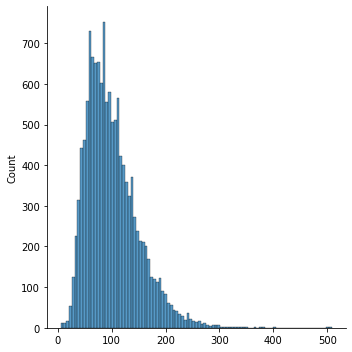

In [7]:
hindi_hdtb_avg_sent_length = [
    len(s.metadata["text"]) for s in tqdm(ud_hindi_hdtb_train)
]
sns.displot(hindi_hdtb_avg_sent_length);

In [8]:
def get_pos_count(data):
    tag_counter = collections.Counter()
    tagged_word_counter = collections.Counter()
    # pos to words
    pos_word_counter = collections.defaultdict(collections.Counter)
    # words to pos
    word_pos_counter = collections.defaultdict(collections.Counter)

    for sent in data:
        for word in sent:
            tag_counter.update({word["upos"]: 1})
            tagged_word_counter.update({word["form"]: 1})
            pos_word_counter[word["upos"]].update({word["form"]: 1})
            word_pos_counter[word["form"]].update({word["upos"]: 1})

    return (
        tag_counter,
        tagged_word_counter,
        pos_word_counter,
        list(word_pos_counter.items()),
    )


(
    hindi_hdtb_tag_counter,
    hindi_hdtb_tagged_word_counter,
    hindi_hdtb_pos_word_counter,
    hindi_hdtb_word_pos_counter,
) = get_pos_count(ud_hindi_hdtb_train)

In [9]:
# Count of POS Tags
hindi_hdtb_tag_counter.most_common()

[('NOUN', 62191),
 ('ADP', 59221),
 ('PROPN', 34289),
 ('VERB', 27188),
 ('AUX', 20821),
 ('PUNCT', 18668),
 ('ADJ', 16459),
 ('PRON', 11857),
 ('DET', 6081),
 ('PART', 5610),
 ('SCONJ', 5389),
 ('NUM', 5332),
 ('CCONJ', 5110),
 ('ADV', 2703),
 ('X', 135),
 ('INTJ', 3)]

In [10]:
# count of words per tag
pos = "ADP"
hindi_hdtb_pos_word_counter[pos].most_common(10)

[('के', 12669),
 ('में', 8416),
 ('की', 6476),
 ('को', 6006),
 ('ने', 4889),
 ('से', 4653),
 ('का', 3514),
 ('पर', 3238),
 ('लिए', 1773),
 ('तक', 673)]

In [11]:
# One word can have more than one tag
hindi_hdtb_word_pos_counter[4]

('बड़ी', Counter({'ADJ': 74, 'PROPN': 2, 'X': 1}))

In [12]:
print(f"Unique tagged words : {len(hindi_hdtb_tagged_word_counter)}")
print(
    f"Total tagged words - {sum([count for word, count in hindi_hdtb_tagged_word_counter.most_common()])}"
)
print(f"Total words in corpus - {sum([len(sent) for sent in ud_hindi_hdtb_train])}")
print()

# Most tagged words
hindi_hdtb_tagged_word_counter.most_common(10)

Unique tagged words : 16879
Total tagged words - 281057
Total words in corpus - 281057



[('के', 12712),
 ('।', 12160),
 ('में', 8421),
 ('की', 7475),
 ('है', 6913),
 ('को', 6006),
 ('ने', 4889),
 ('से', 4747),
 ('कि', 4421),
 ('का', 3517)]

### UD_HINDI_PUD

In [13]:
HINDI_PUD_FOLDER_PATH = (
    "../../../data/pos/interim/1.0-Universal-Dependencies-2.9/UD_Hindi-PUD/"
)
UD_HINDI_PUD_TEST_PATH = os.path.join(HINDI_PUD_FOLDER_PATH, "hi_pud-ud-test.conllu")

ud_hindi_pud_test = parse_conllu(UD_HINDI_PUD_TEST_PATH)

In [14]:
print(f"Total test samples : {len(ud_hindi_pud_test)}")
ud_hindi_pud_test[:5]

Total test samples : 1000


[TokenList<“, संयुक्त, राज्य, अमेरिका, में, ज्यादातर, डिजिटल, संक्रमण, (, ट्रांजिशन, ), जितने, अभूतपूर्व, ढंग, से, हुआ, है, ,, सत्ता, का, शान्तिपूर्ण, संक्रमण, उतना, नहीं, हुआ, ,, ”, ओबामा, के, विशेष, सहायक, कोरी, शुमैन, ने, सोमवार, को, एक, ब्लॉग, पोस्ट, में, लिखा, ।>,
 TokenList<कैपिटल, हिल, में, परिवर्तन, के, संबंध, में, सोशल, मीडिया, पर, नजर, रखने, वाले, लोगों, के, लिए, ,, यह, थोड़ा, अलग, होगा, ।>,
 TokenList<लेकिन, आव्रजन, में, कटौती, के, बारे, में, अपनी, अतीत, की, बयानबाजी, पर, रोक, लगाते, हुए, ,, GOP, नामित, व्यक्ति, ने, घोषणा, की, है, कि, वह, एक, ", योग्यता, प्रणाली, ", के, आधार, पर, ", भारी, संख्या, ", में, कानूनी, आप्रवासियों, को, अनुमति, देगा, ।>,
 TokenList<उत्तरी, कैरोलिना, विश्वविद्यालय, के, खेल, मैदान, पर, एकत्र, भीड़, को, संबोधित, करते, हुए, उन्होंने, कहा, ,, “, इसलिए, मैं, आप, लोगों, पर, थोड़ा, भी, दबाव, डालने, से, नफरत, करता, हूं, ,, लेकिन, गणराज्य, की, किस्मत, आपके, कंधों, पर, टिकी, है, ।, ”>,
 TokenList<क्लिंटन, के, बड़े, बैंक, खाते, की, वजह, से, नये, खर्च, में, वृद्

In [15]:
ud_hindi_pud_test[0][:2]

[{'id': 1,
  'form': '“',
  'lemma': '_',
  'upos': 'PUNCT',
  'xpos': '``',
  'feats': None,
  'head': 16,
  'deprel': 'punct',
  'deps': None,
  'misc': {'SpaceAfter': 'No', 'Translit': '“'}},
 {'id': 2,
  'form': 'संयुक्त',
  'lemma': '_',
  'upos': 'ADJ',
  'xpos': 'JJ',
  'feats': None,
  'head': 4,
  'deprel': 'amod',
  'deps': None,
  'misc': {'Proper': 'True', 'Translit': 'saṁyukta'}}]

  0%|          | 0/1000 [00:00<?, ?it/s]

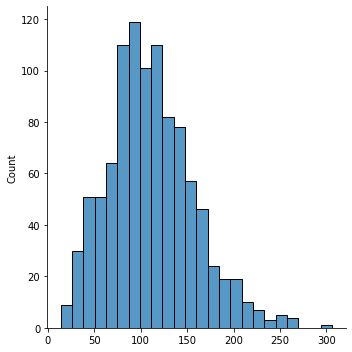

In [16]:
hindi_pud_avg_sent_length = [len(s.metadata["text"]) for s in tqdm(ud_hindi_pud_test)]
sns.displot(hindi_pud_avg_sent_length);

In [17]:
(
    hindi_pud_tag_counter,
    hindi_pud_tagged_word_counter,
    hindi_pud_pos_word_counter,
    hindi_pud_word_pos_counter,
) = get_pos_count(ud_hindi_pud_test)

In [18]:
# Count of POS Tags
hindi_pud_tag_counter.most_common()

[('NOUN', 5597),
 ('ADP', 4849),
 ('PUNCT', 2297),
 ('VERB', 2058),
 ('ADJ', 1995),
 ('AUX', 1776),
 ('PROPN', 1358),
 ('PRON', 1128),
 ('DET', 876),
 ('CCONJ', 545),
 ('NUM', 452),
 ('SCONJ', 382),
 ('PART', 316),
 ('ADV', 159),
 ('SYM', 30),
 ('X', 11)]

In [19]:
# count of words per tag
pos = "CCONJ"
hindi_pud_pos_word_counter[pos].most_common(10)

[('और', 424),
 ('लेकिन', 67),
 ('या', 38),
 ('एवं', 10),
 ('तथा', 3),
 ('एंड', 2),
 ('बहरहाल', 1)]

In [20]:
# One word can have more than one tag
hindi_pud_word_pos_counter[16]

('है', Counter({'AUX': 402, 'VERB': 131}))

In [21]:
print(f"Unique tagged words : {len(hindi_pud_tagged_word_counter)}")
print(
    f"Total tagged words - {sum([count for word, count in hindi_pud_tagged_word_counter.most_common()])}"
)
print(f"Total words in corpus - {sum([len(sent) for sent in ud_hindi_pud_test])}")
print()

# Most tagged words
hindi_pud_tagged_word_counter.most_common(10)

Unique tagged words : 5151
Total tagged words - 23829
Total words in corpus - 23829



[('के', 998),
 ('।', 982),
 ('में', 825),
 (',', 810),
 ('है', 533),
 ('की', 509),
 ('और', 438),
 ('से', 398),
 ('को', 371),
 ('का', 319)]

#### Thoughts
1. Sentences are relatively short across the whole corpus.
2. There is a good amount of imbalance in the tags that needs to be taken care of.
3. Both Datasets have relatively same sentence length distribution, At dataset creation time, sampling should be done appropriately.